In [20]:
import json
from tqdm import tqdm
import pandas as pd
from transformers import BertModel, BertTokenizer
import numpy as np
import torch
from sklearn.model_selection import train_test_split

import random

import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch.nn.functional as f

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
def get_metadata():
    with open("../input/arxiv/arxiv-metadata-oai-snapshot.json") as f:
        for line in f:
            yield line

In [5]:
metadata = get_metadata()

for paper in metadata:
    first_paper = json.loads(paper)
    break
    
for key in first_paper:
    print(key, ':', first_paper[key])

id : 0704.0001
submitter : Pavel Nadolsky
authors : C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-P. Yuan
title : Calculation of prompt diphoton production cross sections at Tevatron and
  LHC energies
comments : 37 pages, 15 figures; published version
journal-ref : Phys.Rev.D76:013009,2007
doi : 10.1103/PhysRevD.76.013009
report-no : ANL-HEP-PR-07-12
categories : hep-ph
license : None
abstract :   A fully differential calculation in perturbative quantum chromodynamics is
presented for the production of massive photon pairs at hadron colliders. All
next-to-leading order perturbative contributions from quark-antiquark,
gluon-(anti)quark, and gluon-gluon subprocesses are included, as well as
all-orders resummation of initial-state gluon radiation valid at
next-to-next-to-leading logarithmic accuracy. The region of phase space is
specified in which the calculation is most reliable. Good agreement is
demonstrated with data from the Fermilab Tevatron, and predictions are made for
more detai

In [6]:
author = [] 
title = []
categories = []
abstract = []

n_journal_publicated = 0

for ind, paper in tqdm(enumerate(metadata)):
    paper = json.loads(paper)
    if paper['journal-ref'] != None:
        n_journal_publicated += 1      
        author.append(paper['submitter'])
        title.append(paper['title'])
        categories.append(paper['categories'])
        abstract.append(paper['abstract'])

print(f'paper publicated on journals is: {n_journal_publicated}')

2061366it [01:01, 33537.03it/s]

paper publicated on journals is: 761112


In [7]:
df = pd.DataFrame({'author':author,
                   'title':title,
                   'categories':categories, 
                   'abstract':abstract})
df.head()

,author,title,categories,abstract
0,Alberto Torchinsky,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,math.CA math.FA,In this paper we show how to compute the $\L...
1,Alejandro Corichi,Polymer Quantum Mechanics and its Continuum Limit,gr-qc,A rather non-standard quantum representation...
2,Damian Swift,Numerical solution of shock and ramp compressi...,cond-mat.mtrl-sci,A general formulation was developed to repre...
3,Paul Harvey,"The Spitzer c2d Survey of Large, Nearby, Inste...",astro-ph,We discuss the results from the combined IRA...
4,Christian Stahn,Fermionic superstring loop amplitudes in the p...,hep-th,The pure spinor formulation of the ten-dimen...


In [8]:
df.shape

(761112, 4)

In [9]:
df = df.iloc[:3000]

In [10]:
texts = list(df.title.values)

In [11]:
bert_version = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(bert_version)
model = BertModel.from_pretrained(bert_version)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [12]:
model = model.eval()

In [13]:
encodings = tokenizer(
    texts,
    padding=True,
    return_tensors='pt'
)

In [14]:
with torch.no_grad():
    embeds = model(**encodings)

In [15]:
embeds = embeds[0]

In [16]:
embeds.shape

torch.Size([3000, 81, 768])

In [17]:
def visualize(distances, figsize=(10, 5), titles=None):
    # get the number of columns
    ncols = len(distances)
    # create the subplot placeholders
    fig, ax = plt.subplots(ncols=ncols, figsize=figsize)
    
    for i in range(ncols):
        
        # get the axis in which we will draw the matrix
        axes = ax[i] if ncols > 1 else ax
        
        # get the i-th distance
        distance = distances[i]
        
        # create the heatmap
        axes.imshow(distance)
        
        # show the ticks
        axes.set_xticks(np.arange(distance.shape[0]))
        axes.set_yticks(np.arange(distance.shape[1]))
        
        # set the tick labels
        axes.set_xticklabels(np.arange(distance.shape[0]))
        axes.set_yticklabels(np.arange(distance.shape[1]))
        
        # set the values in the heatmap
        for j in range(distance.shape[0]):
            for k in range(distance.shape[1]):
                text = axes.text(k, j, str(round(distance[j, k], 3)),
                               ha="center", va="center", color="w")
        
        # set the title of the subplot
        title = titles[i] if titles and len(titles) > i else "Text Distance"
        axes.set_title(title, fontsize="x-large")
        
    fig.tight_layout()
    plt.show()

#### Way 1: Use the [CLS] Embeddings

In [32]:
CLSs = embeds[:5, 0, :]

In [33]:
normalized = f.normalize(CLSs, p=2, dim=1)
cls_dist = normalized.matmul(normalized.T)
cls_dist = cls_dist.new_ones(cls_dist.shape) - cls_dist
cls_dist = cls_dist.numpy()

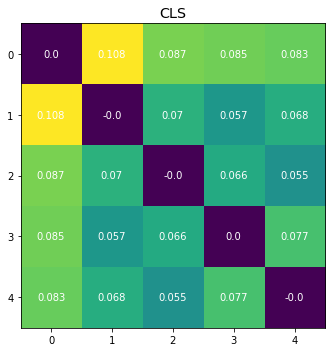

In [34]:
visualize([cls_dist], titles=["CLS"])

#### Way 2: Computing the Mean of All Output Vectors

In [36]:
MEANS = embeds[:5, :, :].mean(dim=1)

In [37]:
normalized = f.normalize(MEANS, p=2, dim=1)
mean_dist = normalized.matmul(normalized.T)
mean_dist = mean_dist.new_ones(mean_dist.shape) - mean_dist
mean_dist = mean_dist.numpy()

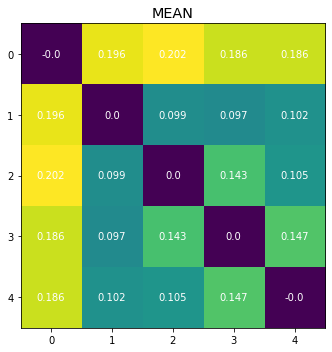

In [38]:
visualize([mean_dist], titles=["MEAN"])

#### Way 3: Compute the max-over-time of the Output Vectors

In [39]:
MAXS, _ = embeds[:5, :, :].max(dim=1)

In [40]:
normalized = f.normalize(MAXS, p=2, dim=1)
max_dist = normalized.matmul(normalized.T)
max_dist = max_dist.new_ones(max_dist.shape) - max_dist
max_dist = max_dist.numpy()

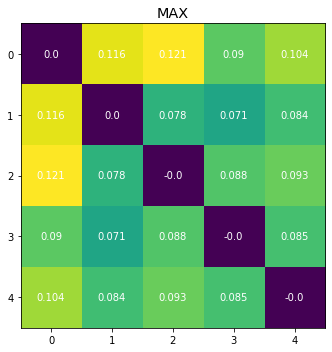

In [41]:
visualize([max_dist], titles=["MAX"])

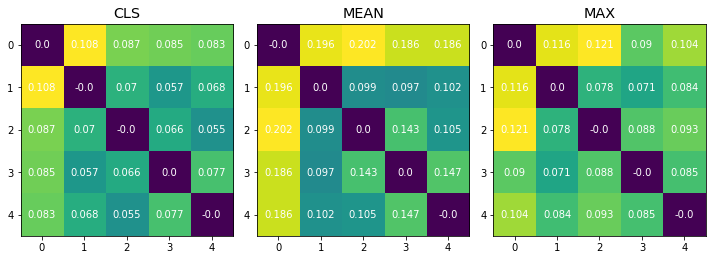

In [42]:
dist = [cls_dist, mean_dist, max_dist]
titles = ["CLS", "MEAN", "MAX"]
visualize(dist, titles=titles)